EVA Assignment 10 - Kaustubh Harapanahalli
# Part 1

### **Import Libraries and modules**

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K

from google.colab.patches import cv2_imshow

import numpy as np
import cv2

from skimage import io

Using TensorFlow backend.


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet")

W0630 07:33:12.455281 139923639912320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 07:33:12.493985 139923639912320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 07:33:12.500636 139923639912320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 07:33:12.535201 139923639912320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 9s 0us/step


W0630 07:33:22.646296 139923639912320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0630 07:33:22.647693 139923639912320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
airplane = io.imread("https://pixel.nymag.com/imgs/fashion/daily/2018/07/04/4-Airplane.w700.h700.jpg")
airplane = cv2.resize(airplane, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(airplane)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]

404


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values
4. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
5. Normalize the heat map to make the values between 0 and 1

In [0]:
layers = ['block5_conv3', 'block5_conv2', 'block5_conv1']

Actual Image


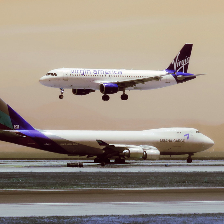

Superimposed Image at: block5_conv3


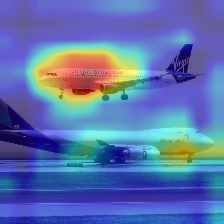





Actual Image


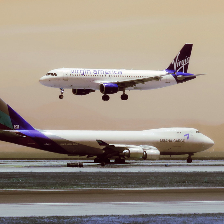

Superimposed Image at: block5_conv2


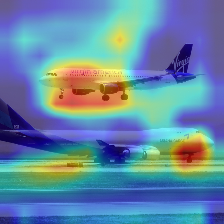





Actual Image


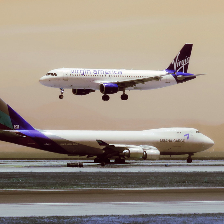

Superimposed Image at: block5_conv1


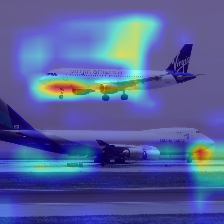

In [0]:
for layer in layers:
    last_conv_layer = model.get_layer(layer)
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (airplane.shape[1], airplane.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(airplane, 0.5, heatmap, 0.5, 0)
    print('Actual Image')
    cv2_imshow(airplane)
    print("Superimposed Image at:", layer)
    cv2_imshow(superimposed_img)
    print('\n\n\n')

### Trying to find the sunglasses on Robert Downey Jr. face

In [0]:
from google.colab import drive

drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
iron_man = io.imread("drive/My Drive/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")
iron_man = cv2.resize(iron_man, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(iron_man)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

#### Here we are loading the image and letting the image to figure out to which class would the model classify the image belonging to

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]

837


In [0]:
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [0]:
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

Actual Image


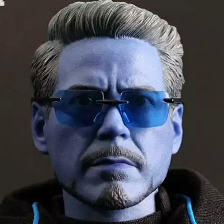




Superimposed Image at: block5_conv1


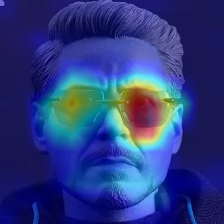

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (iron_man.shape[1], iron_man.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(iron_man, 0.5, heatmap, 0.5, 0)

print('Actual Image')
cv2_imshow(iron_man)
print('\n\n')
print("Superimposed Image at: block5_conv3")
cv2_imshow(superimposed_img)

### Here we are loading the image and the class index value of the sunglasses and obtaining the gradCAM for the loaded image

In [0]:
# Loading the class index directly
class_idx = np.int64(837)

class_output = model.output[:, class_idx]
print(class_output)
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

Tensor("strided_slice_6:0", shape=(?,), dtype=float32)
Tensor("gradients_4/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 14, 14, 512), dtype=float32)


In [0]:
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

Actual Image


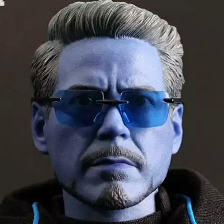




Superimposed Image at: block5_conv1


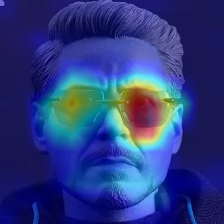

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (iron_man.shape[1], iron_man.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(iron_man, 0.5, heatmap, 0.5, 0)

print('Actual Image')
cv2_imshow(iron_man)
print('\n\n')
print("Superimposed Image at:", layer)
cv2_imshow(superimposed_img)

# Part 2

|Input Shape     |Number of kernels       |Strides       |Receptive Field       |Jump in       |Jump out      |
|- - - |- - - |- - - |- - - |- - - |- - - |
|128x128      |96       |1       |3      |1       |1      |
|128x128      |96       |2       |5      |1       |2      |
|64x64      |48       |1       |9      |2       |2      |
|64x64      |48       |2       |13      |2       |4      |
|32x32      |24       |1       |21      |4       |4      |
|32x32      |24       |2       |29      |4       |8      |
|16x16      |12       |1       |45      |8       |8      |


As we observe here, due to alternating stride values, the jout values increases leading the the Receptive Field reaching to 45 at the end of contracting path. 